# How to forecast a Time Series with AutoArima
---

Wouldn't it be nice to know the future? This is the notebook that relates to the blog post on medium. Please check the blog for visualizations and explanations, this notebook is really just for the code :)

* https://github.com/Pierian-Data/AutoArima-Time-Series-Blog 



## Processing the Data

Let's explore the Industrial production of electric and gas utilities in the United States, from the years 1985-2018, with our frequency being Monthly production output.

You can access this data here: https://fred.stlouisfed.org/series/IPG2211A2N

This data measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

In [1]:
%matplotlib inline
import pandas as pd
data = pd.read_csv("Electric_Production.csv",index_col=0) #here, u can actually already set index via 'index_col=0'
data.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


Right now our index is actually just a list of strings that look like a date, we'll want to adjust these to be timestamps, that way our forecasting analysis will be able to interpret these values:

In [2]:
data.index
# at this point, dates are still string, gotta change to date time

Index(['1985-01-01', '1985-02-01', '1985-03-01', '1985-04-01', '1985-05-01',
       '1985-06-01', '1985-07-01', '1985-08-01', '1985-09-01', '1985-10-01',
       ...
       '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
       '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01'],
      dtype='object', name='DATE', length=397)

In [3]:
data.index = pd.to_datetime(data.index)

In [4]:
data.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [5]:
data.index
# successfully converted to datetime format

DatetimeIndex(['1985-01-01', '1985-02-01', '1985-03-01', '1985-04-01',
               '1985-05-01', '1985-06-01', '1985-07-01', '1985-08-01',
               '1985-09-01', '1985-10-01',
               ...
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
               '2017-12-01', '2018-01-01'],
              dtype='datetime64[ns]', name='DATE', length=397, freq=None)

Let's first make sure that the data doesn't have any missing data points:

In [6]:
data[pd.isnull(data['IPG2211A2N'])]

,IPG2211A2N
DATE,


Let's also rename this column since its hard to remember what "IPG2211A2N" code stands for:

In [7]:
data.columns = ['Energy Production']

In [8]:
data.head()

,Energy Production
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


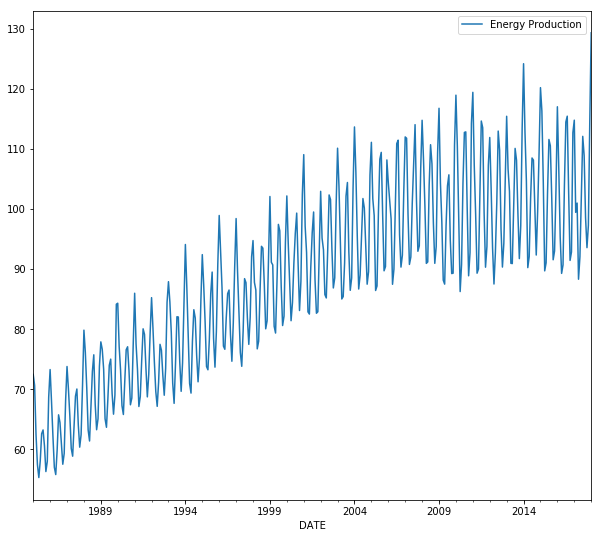

In [9]:
data.plot(figsize=(10,9))

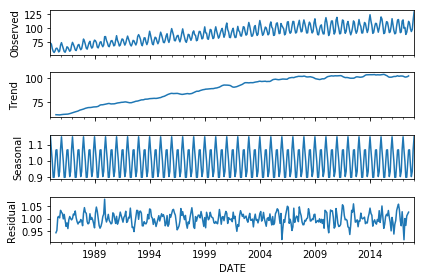

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data, model='multiplicative').plot()

Seasonality is pretty strong here, very random residuals which is good!

# AutoArima

---

https://pypi.org/project/pmdarima 

Pmdarima is a statistical Python library with a solitary objective: bring R's `auto.arima` functionality to Python. Pmdarima operates by wrapping `statsmodels.tsa.ARIMA` and `statsmodels.tsa.statespace.SARIMAX` into one estimator class and creating a more user-friendly estimator interface for programmers familiar with `scikit-learn`.

In [11]:
# !pip install pmdarima
from pmdarima.arima import auto_arima

**he AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [12]:
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True, #seasonal=True gives you SARIMA, not ARIMA
                           d=1, D=1, trace=True, 
                           suppress_warnings=True) 

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1782.527, BIC=1802.280, Fit time=3.517 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2012.117, BIC=2020.018, Fit time=0.026 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1942.041, BIC=1957.844, Fit time=0.380 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1837.289, BIC=1853.091, Fit time=0.777 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2010.162, BIC=2014.112, Fit time=0.037 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1920.884, BIC=1936.687, Fit time=0.703 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1783.894, BIC=1807.598, Fit time=3.234 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at 

In [13]:
stepwise_model.aic() #this gives the best AIC score

1770.2274454596486

## Train Test Split

In [14]:
data.head()

,Energy Production
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
Energy Production    397 non-null float64
dtypes: float64(1)
memory usage: 6.2 KB


We'll train on 20 years of data, from the years 1985-2015 and test our forcast on the years after that and compare it to the real data.

In [18]:
train = data.loc['1985-01-01':'2014-12-01']

In [19]:
train.tail()

,Energy Production
DATE,
2014-08-01,108.1940
2014-09-01,100.4172
2014-10-01,92.3837
2014-11-01,99.7033
2014-12-01,109.3477


In [20]:
test = data.loc['2015-01-01':]

In [21]:
test.head()

,Energy Production
DATE,
2015-01-01,120.2696
2015-02-01,116.3788
2015-03-01,104.4706
2015-04-01,89.7461
2015-05-01,91.0930


In [22]:
test.tail()

,Energy Production
DATE,
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359
2017-12-01,114.7212
2018-01-01,129.4048


In [23]:
len(test)

37

In [24]:
stepwise_model.fit(train)

ARIMA(maxiter=50, method='lbfgs', order=(1, 1, 1), out_of_sample_size=0,
   scoring='mse', scoring_args=None, seasonal_order=(2, 1, 2, 12),
   start_params=None, suppress_warnings=True, trend=None,
   with_intercept=True)

In [25]:
future_forecast = stepwise_model.predict(n_periods=37)

In [26]:
future_forecast

array([118.33702687, 108.88230681, 100.58206799,  89.87355993,
        92.25622142, 102.84979609, 111.87581774, 110.9751753 ,
        99.92871984,  91.89773979,  96.51375503, 109.94293818,
       117.87416113, 108.36596785, 100.4774297 ,  90.2263422 ,
        92.37221305, 102.79460109, 112.42746679, 111.08604142,
        99.76746683,  91.88080261,  96.25154733, 110.45794205,
       118.80723904, 109.00910397, 101.36528334,  90.42511156,
        92.40416235, 102.59344382, 111.85983029, 110.51814696,
        99.86832522,  92.01683697,  96.93246144, 110.48453247,
       119.18741551])

In [27]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])

In [28]:
future_forecast.head()

,Prediction
DATE,
2015-01-01,118.337027
2015-02-01,108.882307
2015-03-01,100.582068
2015-04-01,89.873560
2015-05-01,92.256221


In [29]:
test.head()

,Energy Production
DATE,
2015-01-01,120.2696
2015-02-01,116.3788
2015-03-01,104.4706
2015-04-01,89.7461
2015-05-01,91.0930


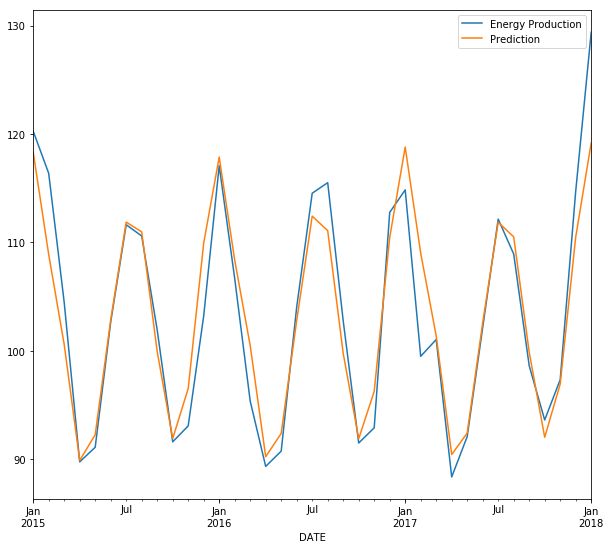

In [30]:
pd.concat([test,future_forecast],axis=1).plot(figsize=(10,9))

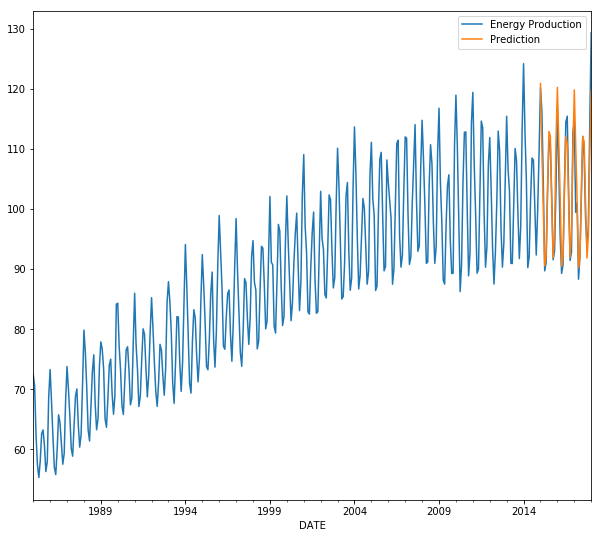

In [31]:
pd.concat([data,future_forecast],axis=1).plot(figsize=(10,9))

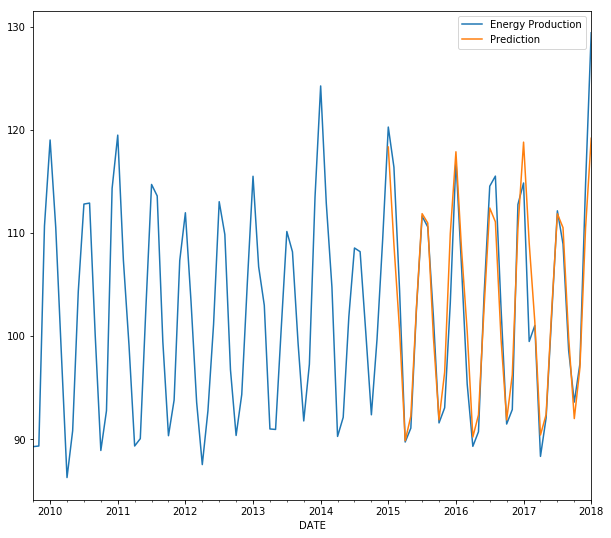

In [31]:
# to zoom in further...
pd.concat([data.tail(100),future_forecast],axis=1).plot(figsize=(10,9))